Garbage Data Classification with EfficientNet

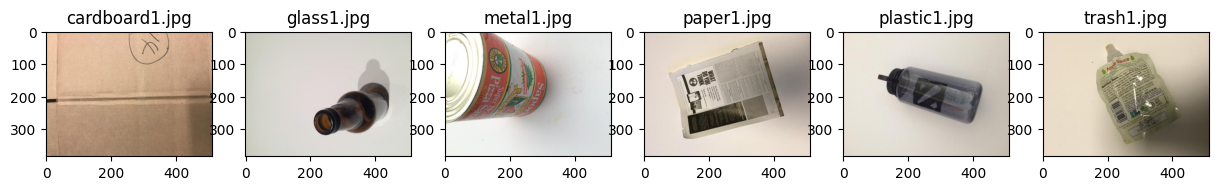

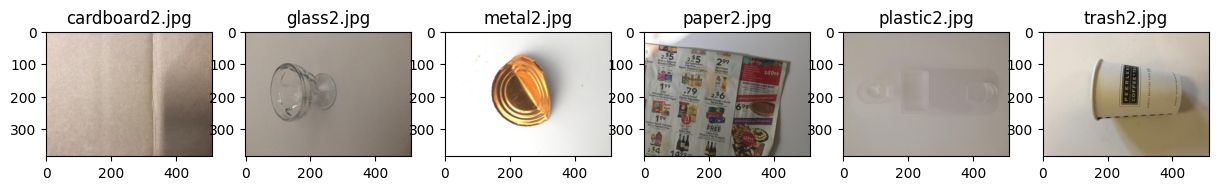

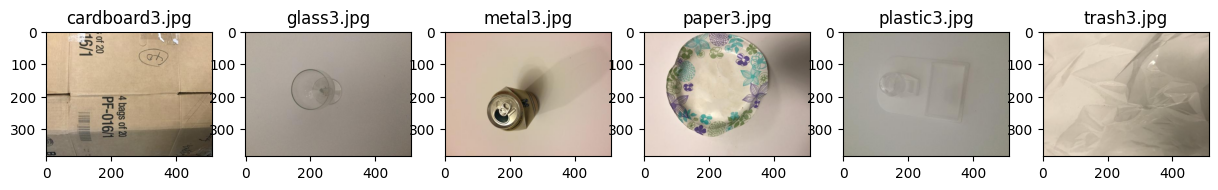

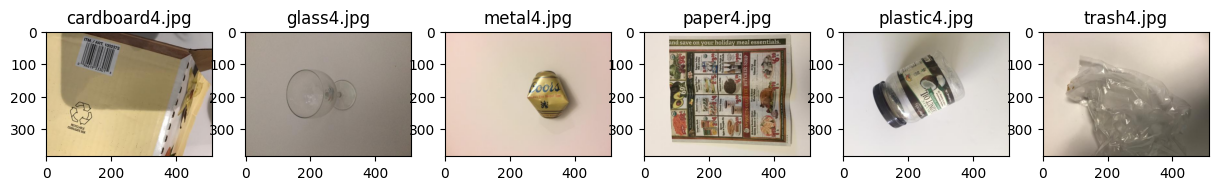

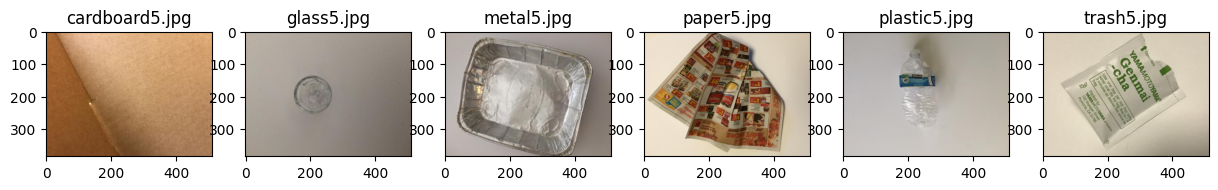

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

dir_main='./data/Garbage classification/'
phase="raw"
classes=['cardboard','glass','metal','paper','plastic','trash']

for i in range(5):
    image_paths=[f"{os.path.join(dir_main,phase,cls,cls+f'{i+1}.jpg')}" for cls in classes]
    images=[Image.open(image_path) for image_path in image_paths]

    fig,axes=plt.subplots(nrows=1,ncols=len(classes), figsize=(15,2))
    for idx, (cls,img) in enumerate(zip(classes,images)):
        axes[idx].set_title(f"{cls}{str(i+1)}.jpg")
        axes[idx].imshow(img)


데이터셋 준비

In [15]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
np.random.seed(724)

dir_main='./data/Garbage classification/'
dir_data_original = os.path.join(dir_main, 'raw')
# 클래스별 디렉토리 추출
classes = [os.path.basename(cls) for cls in glob(f"{dir_data_original}/*")]

img_files=glob(f"{dir_data_original}/*")
img_files = [img_file.replace("\\", "/") for img_file in glob(f"{dir_data_original}/*/*.jpg")]

dataset=np.array([[img_file,img_file.split("/")[-2]] for img_file in img_files])

x=dataset[:,0] # 이미지 파일경로
y=dataset[:,1] #클래스 

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=724)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, random_state=724)

In [16]:
dataset

array([['./data/Garbage classification/raw/cardboard/cardboard1.jpg',
        'cardboard'],
       ['./data/Garbage classification/raw/cardboard/cardboard10.jpg',
        'cardboard'],
       ['./data/Garbage classification/raw/cardboard/cardboard100.jpg',
        'cardboard'],
       ...,
       ['./data/Garbage classification/raw/trash/trash97.jpg', 'trash'],
       ['./data/Garbage classification/raw/trash/trash98.jpg', 'trash'],
       ['./data/Garbage classification/raw/trash/trash99.jpg', 'trash']],
      dtype='<U60')

In [7]:
import os
import shutil

# 저장할 경로 정의
dir_train = os.path.join(dir_main, 'train')
dir_test = os.path.join(dir_main, 'test')
dir_val = os.path.join(dir_main, 'val')

# train, test, val 폴더 생성
def create_directory_structure(base_dir, classes):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.exists(cls_dir):
            os.makedirs(cls_dir)

# 각 클래스별 폴더 생성
create_directory_structure(dir_train, classes)
create_directory_structure(dir_test, classes)
create_directory_structure(dir_val, classes)

# 파일을 해당 폴더로 복사하는 함수
def copy_files_to_directory(file_list, label_list, target_dir):
    for file_path, label in zip(file_list, label_list):
        target_class_dir = os.path.join(target_dir, label)
        shutil.copy2(file_path, target_class_dir)

# 이미지 파일을 복사해서 저장
copy_files_to_directory(x_train, y_train, dir_train)
copy_files_to_directory(x_val, y_val, dir_val)
copy_files_to_directory(x_test, y_test, dir_test)

print("Train, Validation, Test 데이터셋이 성공적으로 분리 및 저장되었습니다.")


Train, Validation, Test 데이터셋이 성공적으로 분리 및 저장되었습니다.


In [17]:
# 클래스별 데이터 개수를 계산하는 함수
def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y] = 0
        cls_cnt[y] += 1
    if cls is None:
        return cls_cnt
    return cls_cnt.get(cls, 0)

# 클래스별 학습, 검증, 테스트 데이터 개수를 출력
print(f"Class\t\tTrain\tVal\tTest\n")
for cls in classes:
    train_count = get_numbers(y_train, cls)
    val_count = get_numbers(y_val, cls)
    test_count = get_numbers(y_test, cls)
    print(f"{cls:10}\t{train_count}\t{val_count}\t{test_count}")

Class		Train	Val	Test

cardboard 	275	55	73
glass     	365	63	73
metal     	278	70	62
paper     	405	103	86
plastic   	347	67	68
trash     	98	21	18


DataLoader Create

Dataset**은 PyTorch에서 데이터셋을 정의하기 위해 사용하는 기본 클래스이며, 이를 상속받아 __getitem__과 __len__ 메서드를 구현하면 PyTorch의 데이터로더와 함께 사용할 수 있는 커스텀 데이터셋만들수 있음

In [19]:
from torch.utils.data import Dataset
# PyTorch Dataset 클래스 정의
class GarbageDataset(Dataset):  # PyTorch의 Dataset 클래스 상속
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(os.path.join(self.dir_dataset, '*', '*.jpg'))
        self.classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        self.tr = tr
    
    def get_image(self, filename):
        img = Image.open(filename).convert('RGB')  # 이미지 파일을 열고 RGB로 변환
        img = self.tr(img)
        return img
    
    def get_label(self, filename):
        cls = filename.split(os.sep)[-2]  # 경로 분리에서 클래스 추출 (플랫폼 독립적)
        if cls not in self.classes:
            raise ValueError(f"Class '{cls}' not found in self.classes list.")
        label = np.array([0] * len(self.classes))  # self.classes의 길이만큼 0으로 채워진 배열
        label[self.classes.index(cls)] = 1  # 원-핫 인코딩
        return torch.from_numpy(label).type(torch.FloatTensor)
    
    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label
    
    def __len__(self):
        return len(self.filelist)
    

# DeviceDataLoader 정의
class DeviceDataLoader():
    def __init__(self, dl):
        self.dl = dl
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    def to_device(self, data):
        if isinstance(data, (list, tuple)):
            return [self.to_device(x) for x in data]
        return data.to(self.device, non_blocking=True)
    
    def __iter__(self):
        for b in self.dl:
            yield self.to_device(b)
    
    def __len__(self):
        return len(self.dl)

import torch
from torch.utils.data import Dataset
from glob import glob
class GarbageDataset(Dataset): #pytorch의 Dataset클래스 상속
    def __init__(self,dir_dataset,tr):
        self.dir_dataset=os.path.abspath(dir_dataset)
        self.filelist=glob(os.path.join(self.dir_dataset, '*', '*.jpg'))
        self.classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        self.tr=tr
    
    def get_image(self,filename):
        img=Image.open(filename)
        img=self.tr(img)
        return img
    
    def get_label(self,filename):
        label=np.array([0]*len(self.classes)) #self.classes의 길이만큼 0으로 채워진 배열
        cls=filename.split('/')[-2]
        label[self.classes.index(cls)]=1 #원-핫 인코딩
        return torch.from_numpy(label).type(torch.FloatTensor)
    
    #PyTorch Dataset 클래스에서 필수적으로 구현해야 하는 메서드로, 
    # 주어진 인덱스(idx)에 해당하는 이미지와 레이블을 반환하는 함수
    def __getitem__(self, idx):
        filename=self.filelist[idx]
        img=self.get_image(filename)
        label=self.get_label(filename)
        return img,label
    #PyTorch Dataset 클래스에서 필수적으로 구현해야 하는 메서드로, 
    # 데이터셋의 전체 길이를 반환합
    def __len__(self):
        return len(self.filelist)

#PyTorch 데이터로더에서 가져오는 데이터(이미지 및 레이블)를 
# CPU나 GPU(사용 가능하면)에 자동으로 전송하여 학습을 더 빠르게 할 수 있도록   

class DeviceDataLoader():
    def __init__(self,dl):
        self.dl=dl
        self.device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#주어진 데이터(텐서)**를 선택된 장치(GPU 또는 CPU)로 옮김
    def to_device(self, data):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list, tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
#데이터로더로부터 배치를 하나씩 가져와서 해당 배치를 GPU 또는 CPU로 이동시킨 후 반환
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield self.to_device(b, self.device)
#전체 배치 수를 반환
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [20]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

'''
Resize: 이미지 크기를 조정합니다.
CenterCrop: 이미지의 중앙 부분을 잘라냅니다.
RandomCrop: 이미지에서 무작위로 부분을 잘라냅니다.
RandomHorizontalFlip: 이미지를 수평 방향으로 무작위로 뒤집습니다.
RandomRotation: 이미지를 주어진 각도 범위 내에서 무작위로 회전시킵니다.
ToTensor: 이미지 데이터를 PyTorch 텐서로 변환합니다.
Normalize: 텐서를 주어진 평균 및 표준 편차 값으로 정규화합니다.
'''
normalize=T.Normalize(
    mean=[0.485,0.456,0.406], #평균적인 이미지의 RGB 의평균 과 표준편차값임
    std=[0.229,0.224,0.225]
)
#Efficientnet 모델의 mean,std가 이렇다
# 'mean': (0.485, 0.456, 0.406),
 #'std': (0.229, 0.224, 0.225),

train_tr=T.Compose([
    T.Resize((256,256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr=T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    normalize
])

train_ds=GarbageDataset(os.path.join(dir_main,"train"),train_tr)
val_ds = GarbageDataset(os.path.join(dir_main, "val"), test_tr)
test_ds = GarbageDataset(os.path.join(dir_main, "test"), test_tr)


#PyTorch에서 데이터를 배치(batch) 단위로 묶고, 모델에 데이터를 효율적으로 공급하기 위한 도구
train_dl=DataLoader(train_ds,shuffle=True,num_workers=0,batch_size=128)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=128)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=128)

train_dl = DeviceDataLoader(train_dl)
val_dl = DeviceDataLoader(val_dl)
test_dl = DeviceDataLoader(test_dl)


### 3. Modeling

#### 3.1. Select Model - EfficientNet

EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks ([Paper](https://arxiv.org/abs/1905.11946)) 이란?

2019년에 나온 Architecture로 Google에서 Neural Architecture 최적화 기법 중 하나인 NAS(Neural Architecture Search)를 찾은 가성비 좋은 Scalable Architecture입니다.
Scalable한 이유는 NAS의 파라미터와 관련이 있습니다. 모델의 크기는 크게 아래 세가지 파라미터로 볼 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=1dvD_KIiNVkj6ntF5QNo_LqfkK_xYLjQ4"  height = 300> </center>
Compound Scaling: EfficientNet은 Width, Depth, Resolution의 3가지 요소를 조절하여 모델의 성능과 효율성을 극대화합니다. 이를 Compound Scaling이라고 부르며, 이전에는 이 3가지 요소를 각각 조절하여 모델을 개발했지만, EfficientNet은 이를 종합적으로 고려하여 최적의 구조를 찾아냅니다.

1. Depth : 네트워크의 깊이로 레이어 수
2. Width : 각 레이어의 채널 수 
3. Resolution : input image의 해상도

<center><img src = "https://drive.google.com/uc?id=1DYrvKQN4Vlq_Pt6RjYKXQMWDIwgPtsRH" height = 400></center>
ImageNet에서 기존 ConvNet보다 8.4배 작으면서 6.1배 빠르고 더 높은 정확도를 갖는다.


<center><img src = "https://drive.google.com/uc?id=19Gq1NPLK333XQbRyEx9qlsNYS3k-xH8t" height = 300></center>
Efficient Blocks: Inverted Residual Block + SE(Squeeze-and-Excitation) Layer의 조합으로 되어있는데 이 구조는 모바일 기기에서도 빠르고 효율적이면서 높은 정확도를 갖게 해줍니다.

- ResNet과는 달리 Residual Connection 대신 Inverted Residual 구조를 기반으로 한 MBConv 레이어를 사용하여 정보 처리를 최적화하고, 네트워크의 크기와 계산 복잡도를 최소화하였습니다.
- SE Layer : 신경망 내의 채널 간의 상호 의존성을 모델링하기 위한 기법
  - Squeeze: 먼저,Global Average Pooling을 사용하여 각 채널별로 정보를 압축합니다. 이 과정에서 공간 정보는 손실되지만, 각 채널의 전반적인 통계 정보를 얻을 수 있습니다.
  - Excitation: Fully Connected Layer을 사용하여 각 채널의 중요성을 학습하는 파라미터를 도출합니다. 일반적으로, 첫 번째 Fully Connected Layer에서는 채널 수를 줄이는 역할을 하며(차원 축소), 두 번째 Fully Connected Layer에서는 activation fucntion을 통해 다시 원래의 채널 수로 복원합니다.
  - Scaling: 마지막으로, 학습된 채널 중요도를 원래의 feature map에 적용하여 각 채널별로 가중치를 조절합니다. 이 과정은 각 채널의 정보를 적절하게 강조하거나 약화시키는 데 도움이 됩니다.
  - SE Layer는 네트워크의 다양한 위치에 추가할 수 있으며, 많은 모델들이 이를 사용하여 성능을 향상시킵니다. 

In [58]:
import timm

In [59]:
#Lodding Model
print(f"The number of pretrained models : {len(timm.list_models('*',pretrained=True))}")
timm.list_models('efficientnet*',pretrained=True)

The number of pretrained models : 1493


['efficientnet_b0.ra4_e3600_r224_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1.ra4_e3600_r240_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

In [60]:
model=timm.create_model('efficientnet_b0.ra_in1k',pretrained=True)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'hf_hub_id': 'timm/efficientnet_b0.ra_in1k',
 'architecture': 'efficientnet_b0',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [61]:
#output dimension 체크
print(model.global_pool)
print(model.get_classifier())

SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=1280, out_features=1000, bias=True)


In [62]:
#1. pooling방법 변경가능하다
import torch

pool_types = ['avg','max','avgmax','catavgmax','']

for pool in pool_types:
    model=timm.create_model('efficientnet_b0.ra_in1k',pretrained=True,num_classes=0,global_pool=pool)
    model.eval()
    feature_output=model(torch.randn(1,3,224,224))
    print(feature_output.shape)

torch.Size([1, 1280])
torch.Size([1, 1280])
torch.Size([1, 1280])
torch.Size([1, 2560])
torch.Size([1, 1280, 7, 7])


In [63]:
#방법1. pooling방법과 클래스 개수 변경
model.reset_classifier(len(classes), 'max')
print(model.global_pool)
print(model.get_classifier())

SelectAdaptivePool2d(pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=1280, out_features=6, bias=True)


In [64]:
#방법2 change to custom fc(fulley connected layer)새롭게 정의
num_in_features = model.get_classifier().in_features
num_in_features 

1280

In [5]:
from torch import nn
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=6, bias=False)
)

NameError: name 'num_in_features' is not defined

In [66]:
#방법3. 처음 불러올때 다 설정하는 법
model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True, num_classes=len(classes), global_pool='avg')

In [67]:
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 6])

In [6]:
#모델 정의
import timm
import torch.nn.functional as F

class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        #모델로드
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = EfficientNet()
#to_device(model, device)

NameError: name 'classes' is not defined

모델 학습

In [81]:
# TrainHelper 클래스 정의
class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        # history는 학습의 이력을 저장하기 위한 리스트입니다. 기본값은 빈 리스트입니다.
        self.history = history
        
        # save_path는 학습 이력을 저장할 파일 경로입니다.
        # 기본 경로는 './ckpt/history.pickle' 입니다.
        self.save_path = save_path
        
        # save_path에서 지정한 파일을 저장할 디렉토리를 생성합니다.
        # os.makedirs()는 지정된 경로의 디렉토리를 생성하며, 
        # exist_ok=True 옵션을 통해 이미 디렉토리가 존재할 경우 에러가 발생하지 않도록 합니다.
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 모델의 예측과 실제 레이블 간의 정확도를 계산하는 함수
    def accuracy(self, outputs, labels):
        # 예측된 클래스 추출 (확률이 가장 큰 클래스 인덱스)
        pred = torch.max(outputs, dim=1)[1]
        
        # 실제 레이블 추출
        gt = torch.max(labels, dim=1)[1]
        
        # 예측과 실제가 같은 개수를 합산하여 정확도 계산
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))
    
    @torch.no_grad()  # 자동 기울기 계산 비활성화(검증 단계에서 파라미터 업데이트 x)
    def validation(self, batch):
        # 배치 데이터를 입력 받음 (이미지와 레이블로 구성)
        images, labels = batch
        
        # 모델을 이용해 예측 수행
        out = model(images)
        
        # 정확도 계산
        acc = self.accuracy(out, labels)
        
        # 손실 계산 (교차 엔트로피 사용)
        loss = F.cross_entropy(out, labels.argmax(dim=1))
        
        # 손실과 정확도 반환 (손실 값은 detach()를 이용해 그래프 추적에서 분리)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    @torch.no_grad()  # 자동 기울기 계산 비활성화 (평가 단계에서는 파라미터 업데이트 x)
    def evaluation(self, model, data_loader):
        # 모델을 평가 모드로 설정 (드롭아웃 등 비활성화)
        model.eval()
        
        # 데이터 로더의 모든 배치에 대해 검증 수행
        outputs = [self.validation(batch) for batch in data_loader]
        
        # 각 배치의 손실 값 추출 및 평균 계산
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        # 각 배치의 정확도 추출 및 평균 계산
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        # 에포크별 손실과 정확도를 딕셔너리로 반환 (소수점 5자리까지 반올림)
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    # 학습 과정의 로그를 출력하고 기록하는 함수
    def logging(self, epoch, result):
        # 학습 결과를 포맷에 맞게 출력
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
        # 학습 이력에 현재 결과를 추가
        self.history.append(result)
        
        # 학습 이력을 파일로 저장 (pickle 사용)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

# TrainHelper 클래스 인스턴스 생성
train_helper = TrainHelper()

In [82]:
train_helper.evaluation(model,val_dl)

{'val_loss': 1.91694, 'val_acc': 0.0871}

In [84]:
# 학습 루프 정의
epochs = 10  # 학습할 에포크 수
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam 옵티마이저 설정

val_acc_best = 0  # 최고 검증 정확도를 저장할 변수
save_model_path = "./ckpt/"  # 모델을 저장할 경로
os.makedirs(save_model_path, exist_ok=True)  # 모델 저장 경로 생성

for epoch in range(epochs):
    # Training Phase
    model.train()  # 모델을 학습 모드로 전환
    train_losses = []  # 학습 손실을 저장할 리스트
    for batch in tqdm(train_dl):  # tqdm을 사용해 학습 진행 상황을 표시
        inputs, targets = batch  # 배치 데이터 가져오기
        outputs = model(inputs)  # 모델에 입력하여 출력 생성
        loss = F.cross_entropy(outputs, targets.argmax(dim=1))  # 손실 함수 계산 (원-핫 인코딩 수정)

        train_losses.append(loss)  # 손실 값 저장
        loss.backward()  # 역전파 수행
        optimizer.step()  # 가중치 업데이트
        optimizer.zero_grad()  # 기울기 초기화

    # Validation phase
    result = train_helper.evaluation(model, val_dl)  # 검증 데이터 평가
    result['train_loss'] = torch.stack(train_losses).mean().item()  # 학습 손실 평균 계산

    # Save the best model
    if result['val_acc'] >= val_acc_best:  # 현재 검증 정확도가 최고 검증 정확도보다 높을 경우
        val_acc_best = result['val_acc']  # 최고 검증 정확도 갱신
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)  # 이전에 저장된 모델 삭제
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)  # 현재 모델 저장
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)  # 학습 로그 기록

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)  # 최종 모델 저장

100%|██████████| 14/14 [03:02<00:00, 13.05s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.60993.pt
Epoch 0: train_loss: 1.6503, val_loss: 1.4992, val_acc: 0.6099


100%|██████████| 14/14 [03:04<00:00, 13.21s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.73327.pt
Epoch 1: train_loss: 1.4027, val_loss: 1.3700, val_acc: 0.7333


100%|██████████| 14/14 [02:59<00:00, 12.84s/it]


Saved PyTorch Model State to ./ckpt/best_ep_2_0.77318.pt
Epoch 2: train_loss: 1.2684, val_loss: 1.2838, val_acc: 0.7732


100%|██████████| 14/14 [03:02<00:00, 13.02s/it]


Saved PyTorch Model State to ./ckpt/best_ep_3_0.81777.pt
Epoch 3: train_loss: 1.1847, val_loss: 1.2403, val_acc: 0.8178


100%|██████████| 14/14 [03:03<00:00, 13.11s/it]


Saved PyTorch Model State to ./ckpt/best_ep_4_0.85726.pt
Epoch 4: train_loss: 1.1366, val_loss: 1.2123, val_acc: 0.8573


100%|██████████| 14/14 [02:59<00:00, 12.83s/it]


Saved PyTorch Model State to ./ckpt/best_ep_5_0.86539.pt
Epoch 5: train_loss: 1.1107, val_loss: 1.1995, val_acc: 0.8654


100%|██████████| 14/14 [03:01<00:00, 12.98s/it]


Saved PyTorch Model State to ./ckpt/best_ep_6_0.8732.pt
Epoch 6: train_loss: 1.0969, val_loss: 1.1915, val_acc: 0.8732


100%|██████████| 14/14 [03:05<00:00, 13.26s/it]


Saved PyTorch Model State to ./ckpt/best_ep_7_0.88351.pt
Epoch 7: train_loss: 1.0813, val_loss: 1.1896, val_acc: 0.8835


100%|██████████| 14/14 [03:02<00:00, 13.03s/it]


Saved PyTorch Model State to ./ckpt/best_ep_8_0.88446.pt
Epoch 8: train_loss: 1.0746, val_loss: 1.1837, val_acc: 0.8845


100%|██████████| 14/14 [03:04<00:00, 13.15s/it]


Epoch 9: train_loss: 1.0719, val_loss: 1.1797, val_acc: 0.8811


##### Train & Validation Losses

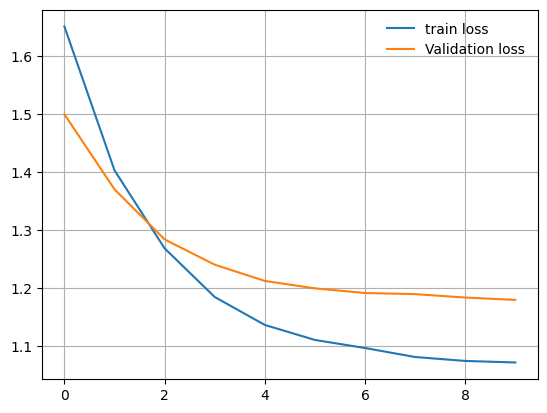

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

### Accuracy

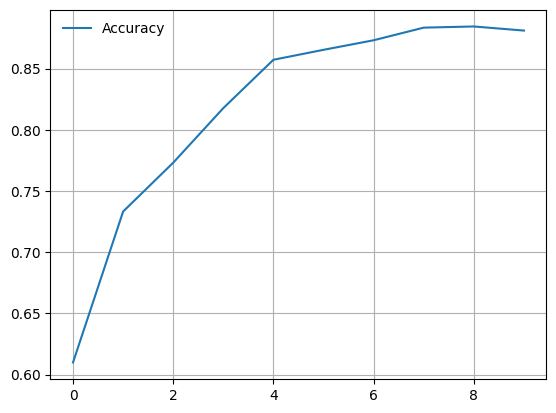

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc=[history['val_acc'] for history in train_helper.history]
plt.plot(val_acc,label='Accuracy')
plt.grid()
plt.legend(frameon=False)

### Analysis
confusion matrix

100%|██████████| 3/3 [01:46<00:00, 35.36s/it]


Classes : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Performance 
              precision    recall  f1-score   support

           0      0.969     0.863     0.913        73
           1      0.848     0.918     0.882        73
           2      0.912     0.839     0.874        62
           3      0.863     0.953     0.906        86
           4      0.843     0.868     0.855        68
           5      0.786     0.611     0.688        18

    accuracy                          0.879       380
   macro avg      0.870     0.842     0.853       380
weighted avg      0.881     0.879     0.878       380



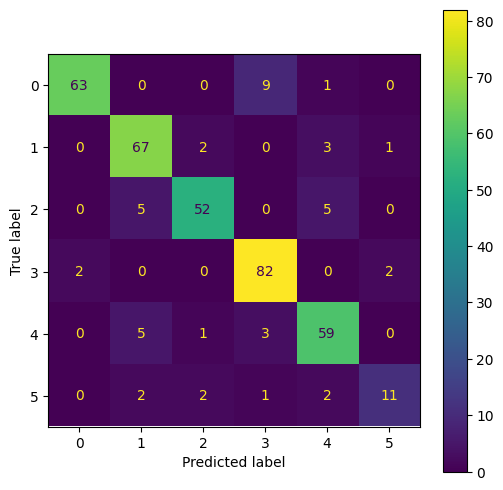

In [87]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred=[]
y_true=[]

for batch in tqdm(test_dl):
    inputs,targets=batch
    outputs=model(inputs)
    y_pred.extend(torch.max(outputs,dim=1)[1].numpy())
    y_true.extend(torch.max(targets,dim=1)[1].numpy())

performance=metrics.classification_report(y_true,y_pred,digits=3)
confusion_matrix=metrics.confusion_matrix(y_true,y_pred)

classes=test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes)) 
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [8]:
#모델 정의
import timm
import torch.nn.functional as F

class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        #모델로드
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=6, global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = EfficientNet()
#to_device(model, device)




In [10]:
import torch
import torch

model=EfficientNet()
model.load_state_dict(torch.load('./ckpt/best_ep_8_0.88446.pt',map_location='cpu'))

C:\Users\djfk7\AppData\Local\Temp\ipykernel_25308\2124099077.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./ckpt/best_ep_8_0.88446.p

<All keys matched successfully>

In [21]:
# Recovery of normalized image dataset for visualization (테스트 시 이미지 원복하기위한 용도)
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive cases

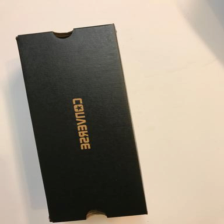

Prediction   : paper (0.9923)
Ground Truth : cardboard


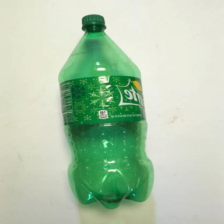

Prediction   : glass (0.9294)
Ground Truth : plastic


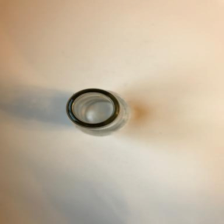

Prediction   : metal (0.9513)
Ground Truth : glass


In [22]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1

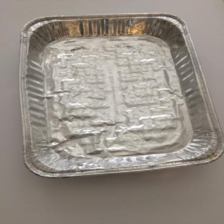

Prediction   : metal (0.3355)
Ground Truth : metal


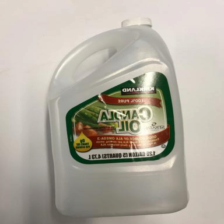

Prediction   : plastic (0.3032)
Ground Truth : plastic


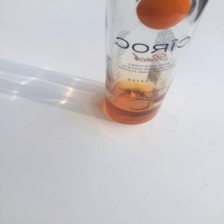

Prediction   : glass (0.1424)
Ground Truth : glass


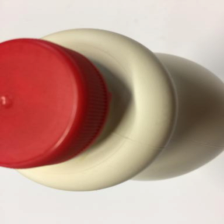

Prediction   : plastic (0.3517)
Ground Truth : plastic


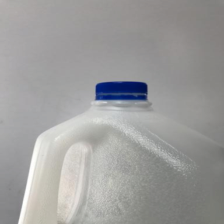

Prediction   : plastic (0.4916)
Ground Truth : plastic


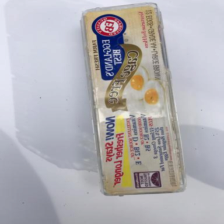

Prediction   : plastic (0.4129)
Ground Truth : plastic


In [23]:
TP = 3  # True Positive를 찾을 횟수 (확신이 낮은 예측 중에서 정확한 예측을 3번 찾을 때까지 반복)
for data in test_dl:  # 테스트 데이터셋에서 배치 단위로 데이터를 불러옴
    if TP <= 0:  # TP가 0이 되면 종료 (3번의 True Positive를 찾으면 반복 종료)
        break
    
    # 데이터 로드: 이미지 배치와 해당하는 레이블 배치를 받음
    img_batch, label_batch = data
    
    # 모델에 이미지 배치를 입력하여 예측 결과를 얻음
    results = model(img_batch)
    
    # 예측된 클래스와 해당 확신(confidence)을 얻음
    confs, preds = torch.max(results, dim=1)
    
    # 원-핫 인코딩된 레이블에서 실제 클래스 인덱스를 얻음
    _, gts = torch.max(label_batch, dim=1)
    
    # 텐서를 Numpy 배열로 변환 (그래디언트 추적 방지 및 CPU에서 처리 가능)
    preds = preds.numpy()  # 예측된 클래스 인덱스
    confs = confs.detach().numpy()  # 예측에 대한 확신 (confidence)
    gts = gts.numpy()  # 실제 정답 클래스 인덱스
    
    # 각 배치의 이미지와 예측, 확신, 실제 정답을 순회
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        
        # 이미지를 정규화된 상태에서 원래 값으로 되돌리고, 시각화를 위해 이미지로 변환
        x = normalize_inverted(img).numpy()  # 정규화된 이미지 텐서를 원래 값으로 변환
        x = (x * 255).astype(np.uint8).T  # 이미지 값을 0~255 범위로 변환하고 전치
        x = Image.fromarray(x)  # Numpy 배열을 PIL 이미지 객체로 변환
        
        # 예측이 정답과 일치하고 확신(confidence)이 0.5 미만인 경우
        if p == g and conf < 0.5:
            display(x)  # 이미지 출력 (Jupyter/IPython 환경에서만 동작)
            
            # 예측된 클래스와 확신도를 출력
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            
            # 실제 정답 클래스 출력
            print(f"Ground Truth : {test_ds.classes[g]}")
            
            TP -= 1  # True Positive 횟수를 하나 줄임